In [1]:
%matplotlib inline

import gc
import re
import nltk
from  nltk import pos_tag
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import langdetect
import warnings

warnings.filterwarnings('ignore')

# code starts here!
stop_words_en = set(stopwords.words("english"))
stemmer_en = SnowballStemmer('english')

SOLUTION_FOR_EVERYTHING = 42

# %env CUDA_VISIBLE_DEVICES='0'

# Data Exploration and Pre-processing

## Size of the dataset


In [2]:
labelled_dataset = pd.read_pickle("data/labelled_dataset.pickle")

# labelled_dataset = labelled_dataset.truncate(after=200)

labelled_dataset.shape[0]

91580

**Sample**

In [3]:
labelled_dataset.head()

,text,labelmax
0,Pros - The people who work here are brilliant ...,customer
1,Pros Start-up vibes Fast growing company Tech-...,customer
2,"Pros The team is great, I love the ambition of...",collaboration
3,"Pros The company is constantly growing, and at...",adaptability
4,Pros Cool office. Friendly people. Good atmosp...,collaboration


In [4]:
labelled_dataset.describe()

,text,labelmax
count,91580,91580
unique,91132,7
top,Pros Favorable environment for learning and gr...,customer
freq,2,26981


In [5]:
labelled_dataset.labelmax.value_counts()

customer         26981
collaboration    21067
result           18948
adaptability     17204
detail            4030
integrity         2815
null               535
Name: labelmax, dtype: int64

In [6]:
labelled_dataset = labelled_dataset[labelled_dataset.labelmax != "null"]
labelled_dataset.describe()

,text,labelmax
count,91045,91045
unique,90602,6
top,Pros Favorable environment for learning and gr...,customer
freq,2,26981


In [7]:
classes_array = sorted(list(labelled_dataset.labelmax.unique()))
classes_array

['adaptability', 'collaboration', 'customer', 'detail', 'integrity', 'result']

In [8]:
labelled_dataset = labelled_dataset.drop_duplicates()
labelled_dataset.describe()

,text,labelmax
count,90602,90602
unique,90602,6
top,Pros Five9 is growing at an extremely quick pa...,customer
freq,1,26851


## Removing non-English texts
By chance, I found that are also texts in German, French, Spanish, and perhaps in some other languages. For the sake of performance, it will only be trained (and accept) English texts. Further improvements can change this.

There are some Python libraries that can help us on the task of langauge classification:

In [9]:
def text_language(text):
    return langdetect.detect(text)
    
labelled_dataset = labelled_dataset[labelled_dataset["text"].apply(text_language) == "en"]
labelled_dataset.describe()

,text,labelmax
count,88264,88264
unique,88264,6
top,Pros Five9 is growing at an extremely quick pa...,customer
freq,1,25918


In [10]:
labelled_dataset.labelmax.value_counts()

customer         25918
collaboration    20527
result           18512
adaptability     16738
detail            3828
integrity         2741
Name: labelmax, dtype: int64

## Segmentation + Tokenization + Stemming + Stop-word removal

Here was concentrated most of the work of this challenge: preparing the text in order to be processed.

Just an additional **trick** added here. Appart from the standard NLP pre-propressing tasks, as the segments of a review text feature the positive and negative aspects of the review, I hypothesize that textual expressions from each of these segments (pros/cons) may have a different influence to the type company culture determination.

For that reason, appart from segmentate a text into pros/cons parts, I'm also adding the text with a prefix (+/-) 

In [11]:
# titles of the sehments
SEGMENT_TITLES = '(Pros |Cons |Advice to Management )'

In [12]:
# returns a segment by it's index in a string splited by SEGMENT_TITLES (i.e.: pros= 2, cons = 4, ...)
def filter_by_segment(entry, index):
    segments = re.split(SEGMENT_TITLES, entry)
    return segments[index]

In [13]:
# performs tokenisation + stemming + stop-word removal
def tok_stem_stop(segment):
    # tokenize and remove empty entries
    tokens = nltk.word_tokenize(segment.lower())
    # stop-word removal, single character tokens removal, and stemming
    tokens = [stemmer_en.stem(_token) for _token in tokens
              if _token not in stop_words_en
              and len(_token) > 1
              and _token not in ["'s", "'d"]
             ]
    # n't -> not
    tokens = [_token.replace("n't", "not") for _token in tokens]
    return " ".join(tokens)

In [14]:
# performs tokenisation + gather just words with POS NN/JJ/VB* + stemming
def tok_pos_stem(segment):
    # tokenize and remove empty entries
    tokens = nltk.word_tokenize(segment.lower())
    # choosing only nouns, verbs, and adjectives
    tokens = [_pos[0] for _pos in pos_tag(tokens) if _pos[1] in ["NN", "NNS", "JJ", "VB", "VBG"]]
    # stemming
    tokens = [stemmer_en.stem(_token) for _token in tokens]
    return " ".join(tokens)

In [15]:
# performs tokenisation + lower case
def tokens(segment):
    return nltk.word_tokenize(segment.lower())

In [16]:
# performs tokenisation + stop-word removal + lower case
def token_stop(segment):
    tokens = nltk.word_tokenize(segment.lower())
    tokens = [_token for _token in tokens
              if _token not in stop_words_en
              and len(_token) > 1
              and _token not in ["'s", "'d"]
             ]
    return tokens

In [17]:
# adds a prefix (e.g.: +/-) to a token
def prefix(entry, _prefix):
    return " ".join([_prefix + _token for _token in entry.split()])

### Adding columns with pre-processed data to the dataframe

In [18]:
labelled_dataset["pros"] = labelled_dataset["text"].apply(lambda entry: filter_by_segment(entry, 2));
labelled_dataset["cons"] = labelled_dataset["text"].apply(lambda entry: filter_by_segment(entry, 4));
labelled_dataset["all"] = labelled_dataset["pros"] + " " + labelled_dataset["cons"];
# labelled_dataset["advice"] = labelled_dataset["text"].apply(lambda entry: filter_by_segment(entry, 6));

In [19]:
labelled_dataset["pros_tokens"] = labelled_dataset["pros"].apply(token_stop);
labelled_dataset["cons_tokens"] = labelled_dataset["cons"].apply(token_stop);
labelled_dataset["all_tokens"] = labelled_dataset["all"].apply(token_stop);

In [20]:
labelled_dataset["pros_tok_stem_stop"] = labelled_dataset["pros"].apply(tok_stem_stop);
labelled_dataset["pros_tok_stem_stop"] = labelled_dataset["pros_tok_stem_stop"].apply(lambda entry: prefix(entry, "+"));
labelled_dataset["cons_tok_stem_stop"] = labelled_dataset["cons"].apply(tok_stem_stop);
labelled_dataset["cons_tok_stem_stop"] = labelled_dataset["cons_tok_stem_stop"].apply(lambda entry: prefix(entry, "-"));

labelled_dataset["all_tok_stem_stop"] = labelled_dataset["pros_tok_stem_stop"] + " " + \
    labelled_dataset["cons_tok_stem_stop"]  

In [21]:
labelled_dataset["pros_tok_pos_stem"] = labelled_dataset["pros"].apply(tok_pos_stem);
labelled_dataset["pros_tok_pos_stem"] = labelled_dataset["pros_tok_pos_stem"].apply(lambda entry: prefix(entry, "+"));
labelled_dataset["cons_tok_pos_stem"] = labelled_dataset["cons"].apply(tok_pos_stem);
labelled_dataset["cons_tok_pos_stem"] = labelled_dataset["cons_tok_pos_stem"].apply(lambda entry: prefix(entry, "-"));

labelled_dataset["all_tok_pos_stem"] = labelled_dataset["pros_tok_pos_stem"] + " " + \
    labelled_dataset["cons_tok_pos_stem"]  

In [22]:
labelled_dataset.head()

,text,labelmax,pros,cons,all,pros_tokens,cons_tokens,all_tokens,pros_tok_stem_stop,cons_tok_stem_stop,all_tok_stem_stop,pros_tok_pos_stem,cons_tok_pos_stem,all_tok_pos_stem
0,Pros - The people who work here are brilliant ...,customer,- The people who work here are brilliant (inte...,- Salary isn't great compared to other grad jo...,- The people who work here are brilliant (inte...,"[people, work, brilliant, intelligent, hard-wo...","[salary, n't, great, compared, grad, jobs, hop...","[people, work, brilliant, intelligent, hard-wo...",+peopl +work +brilliant +intellig +hard-work +...,-salari -not -great -compar -grad -job -hope -...,+peopl +work +brilliant +intellig +hard-work +...,+peopl +brilliant +intellig +hard-work +etc +e...,-salari -great -other -grad -job -improv -comp...,+peopl +brilliant +intellig +hard-work +etc +e...
1,Pros Start-up vibes Fast growing company Tech-...,customer,Start-up vibes Fast growing company Tech-orien...,"Not the best pay, hopefully this will increase...",Start-up vibes Fast growing company Tech-orien...,"[start-up, vibes, fast, growing, company, tech...","[best, pay, hopefully, increase, soon, company...","[start-up, vibes, fast, growing, company, tech...",+start-up +vibe +fast +grow +compani +tech-ori...,-best -pay -hope -increas -soon -compani -grow...,+start-up +vibe +fast +grow +compani +tech-ori...,+start-up +vibe +grow +compani +tech-ori +mana...,-pay -increas -compani -communic -team -improv,+start-up +vibe +grow +compani +tech-ori +mana...
2,"Pros The team is great, I love the ambition of...",collaboration,"The team is great, I love the ambition of the ...",Communication could improve between teams.,"The team is great, I love the ambition of the ...","[team, great, love, ambition, company, great, ...","[communication, could, improve, teams]","[team, great, love, ambition, company, great, ...",+team +great +love +ambit +compani +great +see...,-communic -could -improv -team,+team +great +love +ambit +compani +great +see...,+team +great +i +ambit +compani +great +see +p...,-communic -improv -team,+team +great +i +ambit +compani +great +see +p...
3,"Pros The company is constantly growing, and at...",adaptability,"The company is constantly growing, and at a ve...",Workload isn't always manageable and it can ge...,"The company is constantly growing, and at a ve...","[company, constantly, growing, fast, pace, gre...","[workload, n't, always, manageable, get, quite...","[company, constantly, growing, fast, pace, gre...",+compani +constant +grow +fast +pace +great +c...,-workload -not -alway -manag -get -quit -inten...,+compani +constant +grow +fast +pace +great +c...,+compani +grow +fast +pace +great +cowork +enj...,-workload -manag -get -intens -compani -noth -be,+compani +grow +fast +pace +great +cowork +enj...
4,Pros Cool office. Friendly people. Good atmosp...,collaboration,Cool office. Friendly people. Good atmosphere....,High workload. Low pay. High staff turnover.,Cool office. Friendly people. Good atmosphere....,"[cool, office, friendly, people, good, atmosph...","[high, workload, low, pay, high, staff, turnover]","[cool, office, friendly, people, good, atmosph...",+cool +offic +friend +peopl +good +atmospher +...,-high -workload -low -pay -high -staff -turnov,+cool +offic +friend +peopl +good +atmospher +...,+cool +offic +friend +peopl +good +atmospher +...,-high -workload -low -pay -high -staff -turnov,+cool +offic +friend +peopl +good +atmospher +...


## Reviews length

Tha mnajority of the reviews contain less than 140 words.
**Cons** use to be longer than **pros** (people uses to complain more on Glassdoor?)

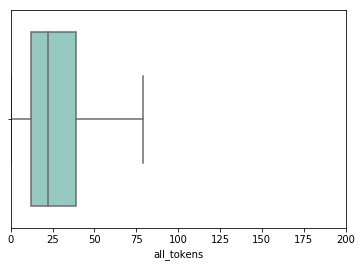

In [23]:
str_lens = labelled_dataset["all_tokens"].apply(len)
plt.xlim(0, 200)
sns.boxplot(str_lens, palette="Set3", showfliers=False);

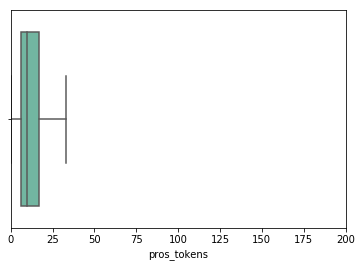

In [24]:
str_lens = labelled_dataset["pros_tokens"].apply(len)
plt.xlim(0, 200)
sns.boxplot(str_lens, palette="Set2", showfliers=False);

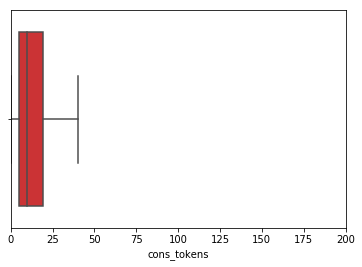

In [25]:
str_lens = labelled_dataset["cons_tokens"].apply(len)
plt.xlim(0, 200)
sns.boxplot(str_lens, palette="Set1", showfliers=False);

## Train / Test datasets

In this exploratory study, I'm going to split the dataset into 80% training and 20% testing. It must be ensured that the same class proportions are kept in the test dataset.

In [26]:
COLUMNS = ["text", "labelmax", "pros", "cons", "all", "pros_tokens", "cons_tokens", "all_tokens", "pros_tok_stem_stop", "cons_tok_stem_stop", "all_tok_stem_stop", "pros_tok_pos_stem", "cons_tok_pos_stem", "all_tok_pos_stem"]

df_train, df_test, _, _ = train_test_split(
    labelled_dataset[COLUMNS],
    labelled_dataset[["labelmax"]],
    stratify=labelled_dataset[["labelmax"]],
    test_size=0.20,
    random_state=SOLUTION_FOR_EVERYTHING
);

## Balancing classes

Classes are not balanced and it may result in a skewed classification based in this data. One solution for this is to oversample minorty classes. As **detail** and **integrity** classes have small subsets, oversampling can also result in skewed results. I'm taking the risk and oversampling all of them:

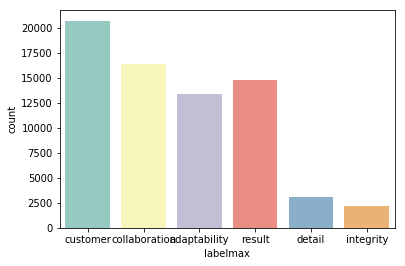

In [27]:
sns.countplot(data=df_train, x="labelmax", palette="Set3");

In [28]:
for _label in set(df_train.labelmax.values):
    ballanced_label_df = resample(
        df_train[df_train.labelmax == _label],
        replace=True,
        n_samples=max(df_train.labelmax.value_counts()),
        random_state=42
    )
    df_train = df_train[df_train.labelmax != _label]
    df_train = pd.concat([df_train, ballanced_label_df])

df_train = df_train.sample(frac=1).reset_index(drop=True)

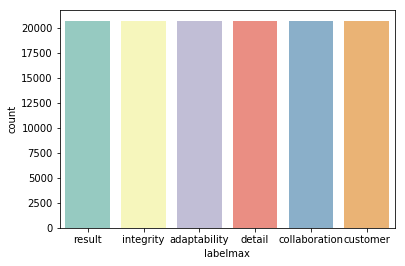

In [29]:
sns.countplot(data=df_train, x="labelmax", palette="Set3");

# Classical TF-IDF approach

The classical approach for text classification uses TF-IDF. In this case, I'm using a SVM instead of a Naïve-Bayes classifier.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline

In [31]:
def tfidf():
    count_vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=500)
    tf_idf = TfidfTransformer(norm="l2")
    svm_clf = SVC()
    tfidf_clf = Pipeline([
        ('count_vectorizer', count_vectorizer),
        ('tf_idf', tf_idf),
        ('svm_clf', svm_clf)
    ])
    return tfidf_clf

In [32]:
text_clf = tfidf()

In [33]:
train_data = df_train.as_matrix(columns=["all_tok_pos_stem"])[:,0]
train_labels = df_train.as_matrix(columns=["labelmax"])[:,0]

text_clf.fit(train_data, train_labels);

In [34]:
predictions = text_clf.predict(df_test.as_matrix(columns=["all_tok_pos_stem"])[:,0])
labels = list(df_test.labelmax)

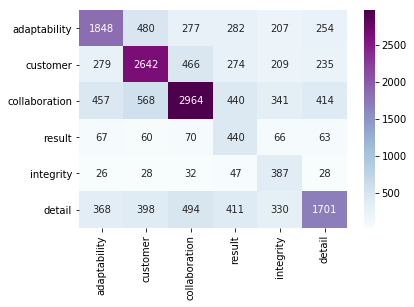

In [35]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(labels, predictions)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="BuPu",
            xticklabels=df_test.labelmax.unique(), yticklabels=df_test.labelmax.unique());

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, predictions, normalize=True)

0.5654562963802187

# CNN (3+3+2) approach

CNNs are among the state-of-the-art of text classification. This is the most well-known CNN implementation (Yoon Kim 2014) for this type of task:

In [37]:
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Embedding, Dense, Convolution1D, ThresholdedReLU, MaxPooling1D, Dropout, Flatten

from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback

from keras import backend as K

Using TensorFlow backend.


In [38]:
# word vectors from Glove, imported as gensim keyvecs
wv = Word2VecKeyedVectors.load("models/wv/word.vectors")
weights = np.load("models/wv/word.vectors.vectors.npy")

In [39]:
SEQUENCE_DIM = 200 # fulfills most of the reviews with 140 words
CLASSES_DIM = len(classes_array) # 6
DROPOUT = 0.1 # maybe...

In [40]:
# turn labels into categorical arrays
train_labelmax = [classes_array.index(row) for row in df_train["labelmax"].as_matrix()]
test_labelmax = [classes_array.index(row) for row in df_test["labelmax"].as_matrix()]

train_cat_labels = to_categorical(np.asarray(train_labelmax))
test_cat_labels = to_categorical(np.asarray(test_labelmax))

In [41]:
def create_embedding_vectors(df, wv):
    
    def vectorise_token(token, wv):
        # just ignoring OOVs
        vector = None
        if token in wv.vocab:
            vector = wv.index2entity.index(token)
        return vector
        
    embedding_vectors = []
    
    for review in df:
        review_embedding = []
        for token in review:
            vector = vectorise_token(token, wv)
            if vector is not None:
                review_embedding.append(vector)
        embedding_vectors.append(review_embedding)

    return embedding_vectors

train_embedding = create_embedding_vectors(df_train["all_tokens"], wv)
test_embedding = create_embedding_vectors(df_test["pros_tokens"], wv)

In [42]:
train_vectors = pad_sequences(train_embedding, maxlen=SEQUENCE_DIM, padding='post')
test_vectors = pad_sequences(test_embedding, maxlen=SEQUENCE_DIM, padding='post')

In [43]:
# build the convnet here!
def convnet(weights, sequence_dim, classes_dim, dropout_val):
    _lexicon_dim = weights.shape[0]
    _embed_dim = weights.shape[1]
    inputs = Input(shape=(sequence_dim,), dtype='int32')
    embed = Embedding(input_dim=_lexicon_dim, output_dim=_embed_dim, weights=[weights])(inputs)

    x = Convolution1D(100, 5, activation='relu')(embed)
    x = MaxPooling1D(5)(x)
    x = Convolution1D(100, 5, activation='relu')(x)
    x = MaxPooling1D(4)(x)
    x = Convolution1D(100, 5, activation='relu')(x)
    x = MaxPooling1D(3)(x)

    flatten = Flatten()(x)
    dropout = Dropout(dropout_val)(flatten)
    x = Dense(100, activation='relu')(dropout)

    outputs = Dense(classes_dim, activation='softmax', name="last_layer")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [44]:
model = convnet(weights, SEQUENCE_DIM, CLASSES_DIM, DROPOUT)

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 50)           20000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 100)          25100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 100)           50100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 100)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 100)            50100     
__________

In [46]:
model.compile(optimizer=Adam(lr=1e-4, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# let's make it faster and avoid the over-fitting that perhaps was arlready happening
early_stop_cb = EarlyStopping(patience=7, monitor='val_acc', mode='max')
checkpoint_cb = ModelCheckpoint("cnn.h5", monitor='val_acc', save_best_only=True, mode='max', verbose=0)

callbacks = [early_stop_cb, checkpoint_cb]

In [48]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13157377984630036036, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 235883724
 locality {
   bus_id: 1
 }
 incarnation: 9359948633398880889
 physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"]

In [49]:
train_vectors.shape

(124404, 200)

In [50]:
history = model.fit(train_vectors, train_cat_labels, callbacks=callbacks, epochs=100, validation_split=0.10, shuffle=True, batch_size=50)

Train on 111963 samples, validate on 12441 samples
Epoch 1/100
111963/111963 [==============================] - 146s 1ms/step - loss: 1.5784 - acc: 0.3499 - val_loss: 1.3339 - val_acc: 0.4836
Epoch 2/100
111963/111963 [==============================] - 144s 1ms/step - loss: 1.2105 - acc: 0.5381 - val_loss: 1.1043 - val_acc: 0.5789
Epoch 3/100
111963/111963 [==============================] - 144s 1ms/step - loss: 1.0078 - acc: 0.6210 - val_loss: 0.9578 - val_acc: 0.6378
Epoch 4/100
111963/111963 [==============================] - 144s 1ms/step - loss: 0.8553 - acc: 0.6813 - val_loss: 0.8330 - val_acc: 0.6856
Epoch 5/100
111963/111963 [==============================] - 145s 1ms/step - loss: 0.7362 - acc: 0.7270 - val_loss: 0.7460 - val_acc: 0.7214
Epoch 6/100
111963/111963 [==============================] - 144s 1ms/step - loss: 0.6370 - acc: 0.7647 - val_loss: 0.6990 - val_acc: 0.7446
Epoch 7/100
111963/111963 [==============================] - 144s 1ms/step - loss: 0.5517 - acc: 0.7983

Validation accuracy:

In [ ]:
max(history.history["val_acc"])

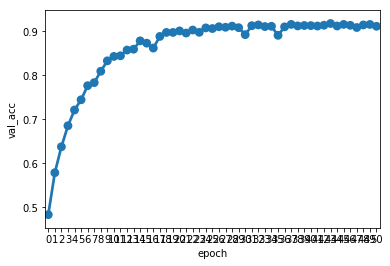

In [52]:
h = {"val_acc": history.history["val_acc"], "epoch": history.epoch}

sns.pointplot(x="epoch", y="val_acc", data=pd.DataFrame.from_dict(h));

Test loss and accuracy:

In [53]:
model.evaluate(test_vectors, test_cat_labels)

17653/17653 [==============================] - 2s 136us/step


[5.08904990075918, 0.45799580808638823]

In [54]:
del model
gc.collect()
K.clear_session()

In [55]:
K.clear_session()

# Results and discussion

The performance of 3 models is evaluated and compared.

In the setup of this experiment, a SVM with stemming and stop-word removal performs better than the other models.

It is statistical significant that CNN performs worse than SVMs in these setup conditions.

In [56]:
import scipy.stats as st

In [57]:
NUM_MODELS = 20
P = 0.05
results_array = []

### Evaluating TF-IDF w/ tok+pos+stem

In [58]:
# dataset for tfidf+tok+pos+stem
train_data = df_train.as_matrix(columns=["all_tok_pos_stem"])[:,0]
train_labels = df_train.as_matrix(columns=["labelmax"])[:,0]
test_data = df_test.as_matrix(columns=["all_tok_pos_stem"])[:,0]
test_labels = list(df_test.labelmax)

In [59]:
for _ in range(0, 1):
    clf = tfidf()
    clf.fit(train_data, train_labels);
    predictions = clf.predict(test_data)
    accuracy = accuracy_score(test_labels, predictions, normalize=True)
    result = {"model": "tfidf+tok+pos+stem", "acc": accuracy}
    results_array.append(result)

### Evaluating TF-IDF w/ tok+stem+stop

In [60]:
# dataset for tfidf+tok+stem+stop
train_data = df_train.as_matrix(columns=["all_tok_stem_stop"])[:,0]
train_labels = df_train.as_matrix(columns=["labelmax"])[:,0]
test_data = df_test.as_matrix(columns=["all_tok_stem_stop"])[:,0]
test_labels = list(df_test.labelmax)

In [61]:
for _ in range(0, 1):
    clf = tfidf()
    clf.fit(train_data, train_labels);
    predictions = clf.predict(test_data)
    accuracy = accuracy_score(test_labels, predictions, normalize=True)
    result = {"model": "tfidf+tok+stem+stop", "acc": accuracy}
    results_array.append(result)

### Evaluating CNN

In [62]:
for _ in range(0, 20):
    model = convnet(weights, SEQUENCE_DIM, CLASSES_DIM, DROPOUT)
    model.compile(optimizer=Adam(lr=1e-4, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_vectors, train_cat_labels, epochs=10, validation_split=0.10, shuffle=True, batch_size=50, verbose=0)
    
    accuracy = model.evaluate(test_vectors, test_cat_labels)[1];
    result = {"model": "cnn", "acc": accuracy}
    results_array.append(result)
    del model
    gc.collect()
    K.clear_session()

17653/17653 [==============================] - 2s 129us/step


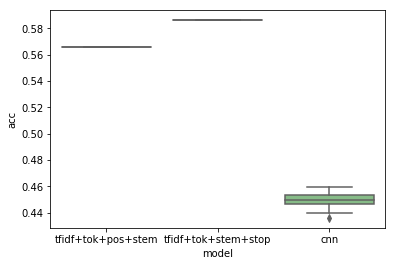

In [63]:
sns.boxplot(x="model", y="acc", data=pd.DataFrame.from_dict(results_array), palette="PRGn")

In [64]:
gc.collect();

### Statistical significance

In [65]:
[result["acc"] for result in results_array if result["model"] == "tfidf+tok+pos+stem"]

[0.5654562963802187]

In [66]:
[result["acc"] for result in results_array if result["model"] == "tfidf+tok+stem+stop"]

[0.5860193734775959]

In [67]:
distr = [result["acc"] for result in results_array if result["model"] == "cnn"]
st.t.interval(0.95, len(distr) - 1, loc=np.mean(distr), scale=st.sem(distr))

(0.44401433132061807, 0.45429190561676647)